In [211]:
import pandas as pd
import geopandas

# prevent false warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import rasterio
from rasterio.plot import show
import fiona
import rasterio
import rasterio.mask

import matplotlib.colors


In [460]:
tiff = '/Users/jona/Downloads/E020N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif'
tiff = '/Users/jona/Downloads/out.tif'

mask = '../input/shapes/Districts/Mtwara DC.shp'

In [461]:
with fiona.open(mask, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [470]:
with rasterio.open(tiff) as src:
    nodata=src.nodata
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=nodata)
    out_meta = src.meta
    
    band_meta = src.tags(1)
    
    band1 = src.read(1, masked=True)
    
    # read color map for band
    #color = src.colormap(1)

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [452]:
# create colormap for matplotlib based on input geotiff.
# remeber to use vmin and vmax: vmin=0, vmax=len(cmap.colors)
palette = np.array(list(color.values()))

# drop alpha
palette = np.delete(palette, -1, axis=1)


# rgb values need to be defined between 0 and 1, so divide by 255
cmap = matplotlib.colors.ListedColormap(palette / 255)

#cmap, norm = matplotlib.colors.from_levels_and_colors(list(color.keys()), palette / 255)


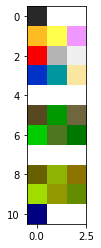

In [453]:
# test color map
plt.imshow([[0, np.nan, np.nan],
            [20, 30, 40], 
            [50, 60, 70],
            [80, 90, 100],
            [np.nan, np.nan, np.nan],
            [111, 112, 113],
            
           [114, 115, 116],
            [np.nan, np.nan, np.nan],
           [121, 122, 123],
           [124, 125, 126],
            
           [200, np.nan, np.nan],
            
           ], cmap=cmap, vmin=0, vmax=255, interpolation='none')
plt.show()


In [454]:
# extract menaings from geotiff meta
flag_meanings = [x.strip() for x in band_meta['flag_meanings'].split(',')]
flag_values   = [int(x.strip()) for x in band_meta['flag_values'].split(',')] 

flags = []
for i in range(0, len(flag_meanings)):
    flags.append({
        'meaning': flag_meanings[i],
        'value': flag_values[i]
    })

In [455]:
meanings_df = pd.DataFrame(flags)

In [511]:
meanings_df.to_json(orient="records")

'[{"meaning":"unknown","value":0},{"meaning":"ENF_closed","value":111},{"meaning":"EBF_closed","value":112},{"meaning":"DNF_closed","value":113},{"meaning":"DBF_closed","value":114},{"meaning":"mixed _closed","value":115},{"meaning":"unknown_closed","value":116},{"meaning":"ENF_open","value":121},{"meaning":"EBF_open","value":122},{"meaning":"DNF_open","value":123},{"meaning":"DBF_open","value":124},{"meaning":"mixed _open","value":125},{"meaning":"unknown_open","value":126},{"meaning":"shrubland","value":20},{"meaning":"herbaceous_vegetation","value":30},{"meaning":"cropland","value":40},{"meaning":"built-up","value":50},{"meaning":"bare_sparse_vegetation","value":60},{"meaning":"snow_ice","value":70},{"meaning":"permanent_inland_water","value":80},{"meaning":"herbaceous_wetland","value":90},{"meaning":"moss_lichen","value":100},{"meaning":"sea","value":200}]'

In [493]:
print(meanings_df.to_markdown(index=False))

| meaning                |   value |
|:-----------------------|--------:|
| unknown                |       0 |
| ENF_closed             |     111 |
| EBF_closed             |     112 |
| DNF_closed             |     113 |
| DBF_closed             |     114 |
| mixed _closed          |     115 |
| unknown_closed         |     116 |
| ENF_open               |     121 |
| EBF_open               |     122 |
| DNF_open               |     123 |
| DBF_open               |     124 |
| mixed _open            |     125 |
| unknown_open           |     126 |
| shrubland              |      20 |
| herbaceous_vegetation  |      30 |
| cropland               |      40 |
| built-up               |      50 |
| bare_sparse_vegetation |      60 |
| snow_ice               |      70 |
| permanent_inland_water |      80 |
| herbaceous_wetland     |      90 |
| moss_lichen            |     100 |
| sea                    |     200 |


In [471]:
band1 = out_image[0]
band1 = band1.astype(np.float32)
band1[band1 == 255] = np.nan

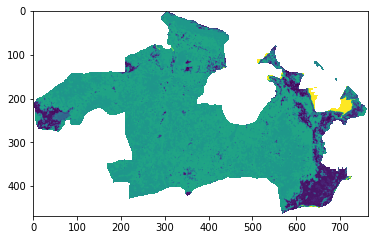

In [472]:
plt.imshow(band1)
plt.show()

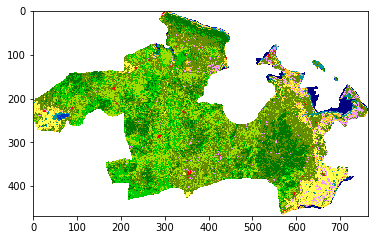

In [473]:
plt.imshow(band1, cmap=cmap, vmin=0, vmax=255, interpolation='none')
plt.show()

In [474]:
band1

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [475]:
with rasterio.open("test.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [514]:
values, count = np.unique(band1, return_counts=True)

In [516]:
values

array([ 20.,  30.,  40.,  50.,  60.,  80.,  90., 112., 114., 116., 122.,
       124., 126., 200.,  nan], dtype=float32)

In [515]:
count

array([  3709,  10802,   5414,    658,    284,    654,   2639,    102,
        22896,  26389,      1,  29829,  55158,   2965, 196052])

In [517]:
counts = dict(zip(values, count))

In [518]:
counts

{20.0: 3709,
 30.0: 10802,
 40.0: 5414,
 50.0: 658,
 60.0: 284,
 80.0: 654,
 90.0: 2639,
 112.0: 102,
 114.0: 22896,
 116.0: 26389,
 122.0: 1,
 124.0: 29829,
 126.0: 55158,
 200.0: 2965,
 nan: 196052}

In [484]:
dfx = pd.DataFrame.from_records(c)

In [486]:
dfx.transpose()

,0,1
0,20.0,3709.0
1,30.0,10802.0
2,40.0,5414.0
3,50.0,658.0
4,60.0,284.0
5,80.0,654.0
6,90.0,2639.0
7,112.0,102.0
8,114.0,22896.0
9,116.0,26389.0


# Our areas of interest from the cupernicus data

In [477]:
copernicus_mappings = [
    {
        'name': 'crop',
        'values': [40]
    },
    {
        'name': 'for',
        'values': [111, 112, 113, 114, 115, 116, 124, 126]
    },
    {
        'name': 'shrub',
        'values': [20]
    },
    {
        'name': 'built',
        'values': [50]
    },
    {
        'name': 'water',
        'values': [80]
    },
    {
        'name': 'wet',
        'values': [90]
    },
]

<AxesSubplot:ylabel='value'>

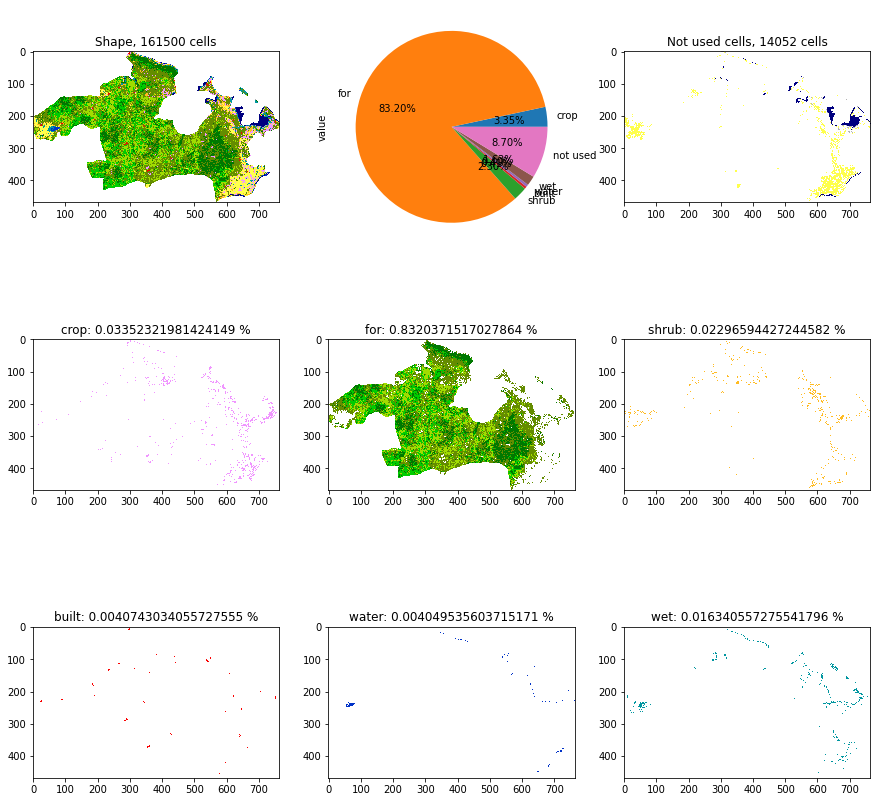

In [478]:
base = out_image[0]
base = base.astype(np.float32)
base[base == 255] = np.nan
total_cells = np.count_nonzero(~np.isnan(base))

fig, axs = plt.subplots(3, 3, figsize=(15,15)) # rows, cols

axs[0][0].imshow(base, cmap=cmap, vmin=0, vmax=len(cmap.colors), interpolation='none')
axs[0][0].set_title(f"Shape, {total_cells} cells")
#axs[0][0].show()

stats = []
all_mask = None

i_row = 1
i_col = 0
for mapping in copernicus_mappings:
    tmp = out_image[0]
    tmp = tmp.astype(np.float32)
    
    # create binary map of values for area of interest
    mask = np.isin(tmp, mapping['values'])
    
    if all_mask is None:
        all_mask = mask
    else:
        all_mask = np.logical_or(all_mask, mask)
    
    # invert mask and by that set everythin NOT in the 
    # area of interst to NaN
    tmp[~mask] = np.nan
    
    aoi_cells = np.count_nonzero(~np.isnan(tmp))

    axs[i_row][i_col].imshow(tmp, cmap=cmap, vmin=0, vmax=len(cmap.colors)-1, interpolation='none')
    axs[i_row][i_col].set_title(f"{mapping['name']}: {aoi_cells/total_cells} %")
    
    stats.append({
        'name': mapping['name'],
        'value': aoi_cells/total_cells,
        'cells': aoi_cells,
    }) 
    
    i_col = (i_col+1) % 3
    
    if i_col == 0:
        i_row += 1
    
    #plt.imshow(tmp)
    #plt.title(f"{mapping['name']}: {aoi_cells/total_cells} {aoi_cells}")
    #plt.show()
    
unkown = base
unkown[all_mask] = np.nan
unused_cells = np.count_nonzero(~np.isnan(unkown))
axs[0][2].imshow(unkown, cmap=cmap, vmin=0, vmax=len(cmap.colors), interpolation='none')
axs[0][2].set_title(f"Not used cells, {unused_cells} cells")
#axs[0][0].show()

stats.append({
    'name': 'not used',
    'value': unused_cells/total_cells,
    'cells': unused_cells,
}) 

stats_df = pd.DataFrame(stats)
stats_df = stats_df.set_index('name')

stats_df.plot.pie(y='value', ax=axs[0][1], autopct='%1.2f%%', legend=False)

In [524]:
stats_df['value'].sum()

1.0

In [525]:
stats_df

,value,cells
name,,
crop,0.033523,5414
for,0.832037,134374
shrub,0.022966,3709
built,0.004074,658
water,0.004050,654
wet,0.016341,2639
not used,0.087009,14052


In [495]:
tiles = {
    'E020N00': [
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2016/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2016-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2017/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2017-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2018/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2018-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif',
    ],
    'E040N00': [
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2016/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2016-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2017/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2017-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2018/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2018-conso_Discrete-Classification-map_EPSG-4326.tif',
        'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif',
    ]
}


In [521]:
for tile, urls in tiles.items():
    for url in urls:
        print(tile, url)




E020N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif
E020N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2016/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2016-conso_Discrete-Classification-map_EPSG-4326.tif
E020N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2017/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2017-conso_Discrete-Classification-map_EPSG-4326.tif
E020N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2018/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2018-conso_Discrete-Classification-map_EPSG-4326.tif
E020N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif
E040N00 https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/E040N00/E040N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete

In [503]:
for i, year in enumerate(range(2015, 2019 + 1)):
    print(i, year)

0 2015
1 2016
2 2017
3 2018
4 2019
